# Literary Knowledge Network – Cluster Timeline Explorer

Visualize the publication timeline for works inside a single community.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')

In [2]:
REPO_ROOT = Path('..').resolve()
paths = {
    'work_enriched': REPO_ROOT / 'data/processed/enriched/work_final.parquet',
    'work_communities': REPO_ROOT / 'data/output/communities/work_communities.parquet',
}

work_df = pd.read_parquet(paths['work_enriched'])
community_df = pd.read_parquet(paths['work_communities'])
print(f'Loaded {len(work_df)} works and {len(community_df)} community assignments.')

Loaded 3581 works and 2470 community assignments.


## Timeline Utilities

In [3]:
def prepare_cluster_frame(cluster_id: int, resolution: float = 1.0) -> pd.DataFrame:
    subset = community_df[(community_df['cluster_id'] == cluster_id) & (community_df['cluster_resolution'] == resolution)]
    if subset.empty:
        raise ValueError(f'Cluster {cluster_id} at resolution {resolution} not found.')
    merged = subset.merge(work_df, on='work_id', how='left', suffixes=('', '_work'))
    return merged


def plot_cluster_timeline(cluster_id: int, resolution: float = 1.0, annotate: bool = True):
    cluster_frame = prepare_cluster_frame(cluster_id, resolution)
    date_columns = ['original_publication_year', 'original_publication_month', 'original_publication_day']

    for col in date_columns:
        if col not in cluster_frame.columns:
            cluster_frame[col] = np.nan

    cluster_frame['publication_date'] = pd.to_datetime(
        cluster_frame[['original_publication_year', 'original_publication_month', 'original_publication_day']]
        .rename(columns={'original_publication_year': 'year', 'original_publication_month': 'month', 'original_publication_day': 'day'}),
        errors='coerce'
    )
    cluster_frame['publication_year'] = cluster_frame['publication_date'].dt.year

    timeline_df = cluster_frame.dropna(subset=['publication_year']).sort_values('publication_year')

    if timeline_df.empty:
        print('No publication years available for this cluster.')
    else:
        plt.figure(figsize=(12, 6))
        sns.scatterplot(
            data=timeline_df,
            x='publication_year',
            y=np.zeros(len(timeline_df)),
            hue='publication_year',
            palette='viridis',
            legend=False,
        )
        plt.yticks([])
        plt.xlabel('Publication Year')
        plt.title(f'Cluster {cluster_id} Timeline (Resolution {resolution})')

        if annotate:
            offsets = np.linspace(-0.4, 0.4, num=max(len(timeline_df), 2))
            for idx, (_, row) in enumerate(timeline_df.iterrows()):
                label = row.get('original_title') or row.get('best_book_id') or row.get('work_id')
                y_offset = offsets[idx % len(offsets)]
                plt.annotate(
                    label,
                    (row['publication_year'], y_offset),
                    xytext=(0, 6),
                    textcoords='offset points',
                    rotation=30,
                    ha='center',
                    fontsize=9,
                )

        plt.tight_layout()
        plt.show()

    display_columns = ['work_id', 'original_title', 'publication_year', 'best_book_id', 'cluster_size']
    display(timeline_df[display_columns])

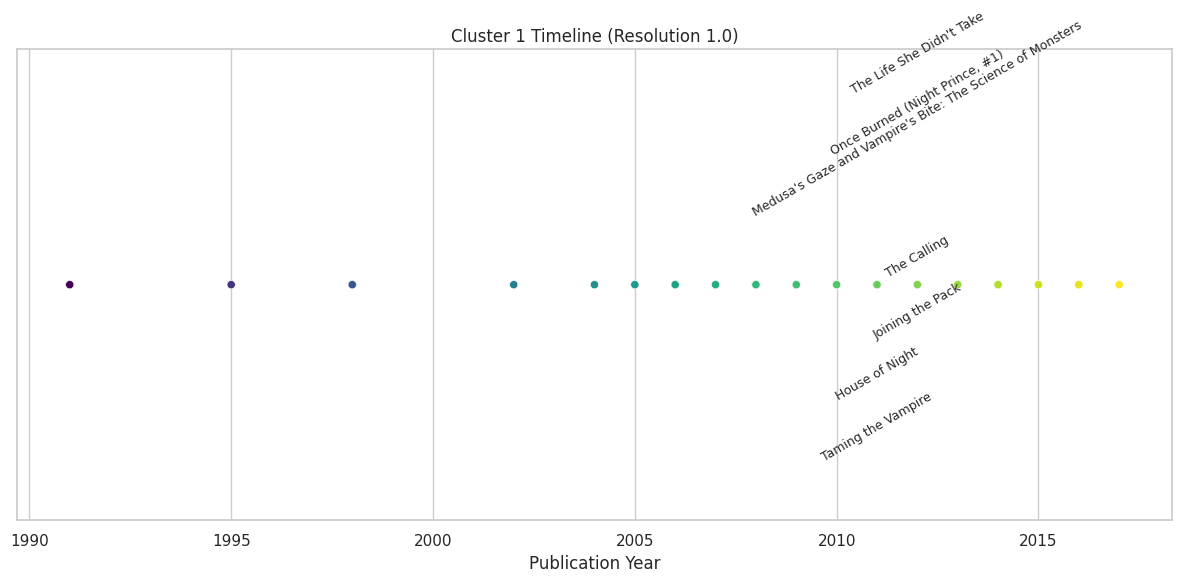

,work_id,original_title,publication_year,best_book_id,cluster_size
57,2590816,"The Vampire Files, Volume 1 (Omnibus: Bloodlis...",1991.0,290437,189
96,2815324,Once An Outlaw,1995.0,2789557,189
100,353853,Daughter of the Blood,1998.0,47956,189
32,1612164,An Unlikely Alliance (Zebra Regency Romance),1998.0,24955376,189
52,905604,The Science of Vampires,2002.0,920570,189
99,30653,Cravings,2004.0,30282,189
130,5542535,A Summer Sentence,2005.0,18800391,189
129,5374456,Vampire Close,2006.0,5306998,189
132,636502,The Forsaken,2006.0,39304,189
10,525790,"Bad Blood (Crimson Moon, #1)",2007.0,538381,189


In [4]:
plot_cluster_timeline(cluster_id=1)

## Usage

Run `plot_cluster_timeline(cluster_id=<id>, resolution=1.0)` to inspect a cluster.